# Fake News Detection Using RNN 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png"> 

This notebook aims to classify fake news from real news using a recurrent neural network. To simplify the text preprocessing precodure, we will be using the built in functions from tensorflow instead of more established libaries like NLTK. 

**Here are the results: **

* Accuracy on testing set: 0.9900890868596882
* Precision on testing set: 0.9865678554886521
* Recall on testing set: 0.9927755767886274


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
import itertools 
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the data 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/research/totaldata.csv")

Combining the title with the text, it is much easier to process this way. 

In [ ]:
df['text'] = df['headline'] + df['content']
df.drop('headline', axis=1, inplace=True)

Split into training and testing 

In [ ]:
features = df['text']
targets = df['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data. 

In [ ]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article 

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

We are going to use early stop, which stops when the validation loss no longer improve.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
275/275 [==============================] - 89s 303ms/step - loss: 0.4603 - accuracy: 0.6676 - val_loss: 0.3601 - val_accuracy: 0.8634
Epoch 2/10
275/275 [==============================] - 84s 304ms/step - loss: 0.2348 - accuracy: 0.9135 - val_loss: 0.2007 - val_accuracy: 0.9213
Epoch 3/10
275/275 [==============================] - 83s 303ms/step - loss: 0.1596 - accuracy: 0.9496 - val_loss: 0.1611 - val_accuracy: 0.9454
Epoch 4/10
275/275 [==============================] - 83s 303ms/step - loss: 0.1024 - accuracy: 0.9730 - val_loss: 0.1402 - val_accuracy: 0.9563
Epoch 5/10
275/275 [==============================] - 83s 301ms/step - loss: 0.0747 - accuracy: 0.9836 - val_loss: 0.1382 - val_accuracy: 0.9617
Epoch 6/10
275/275 [==============================] - 83s 302ms/step - loss: 0.0573 - accuracy: 0.9894 - val_loss: 0.1457 - val_accuracy: 0.9617
Epoch 7/10
275/275 [==============================] - 83s 300ms/step - loss: 0.0479 - accuracy: 0.9922 - val_loss: 0.1359 - val_ac

Visualize our training over time 

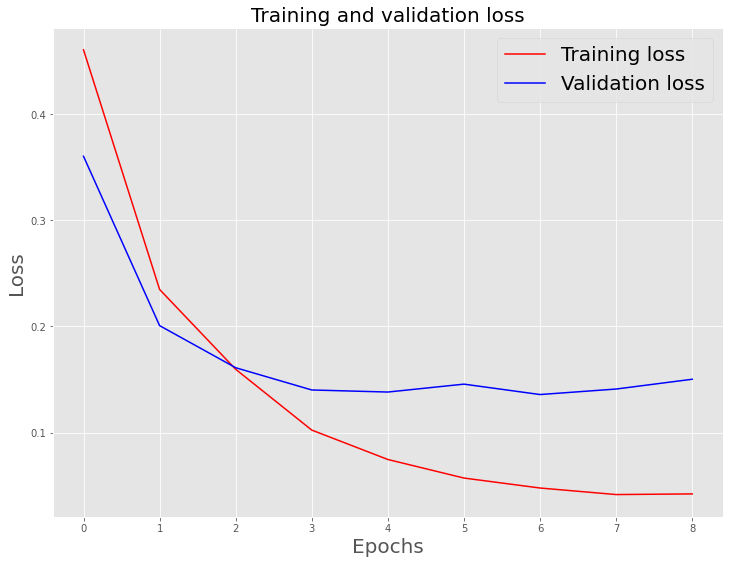

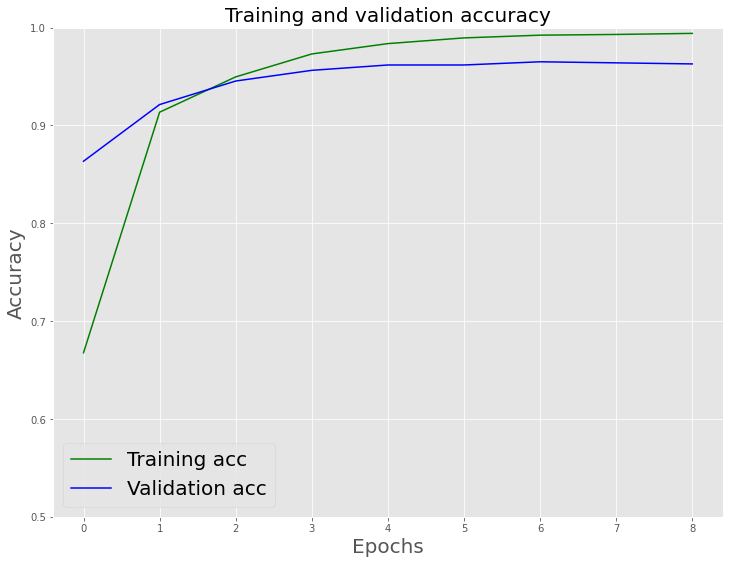

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set 

In [ ]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 4s 61ms/step - loss: 0.1334 - accuracy: 0.9655


[0.1333940029144287, 0.9654569029808044]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('Classification Report: \n', classification_report(binary_predictions, y_test))

Accuracy on testing set: 0.9654569304766069
Precision on testing set: 0.9890164752870694
Recall on testing set: 0.9720314033366045
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       249
           1       0.99      0.97      0.98      2038

    accuracy                           0.97      2287
   macro avg       0.89      0.94      0.92      2287
weighted avg       0.97      0.97      0.97      2287



In [ ]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix', cmap = plt.cm.Greens):
    plt.imshow(cm,interpolation = 'nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized CM")
    else:
        print("CM not normalized")
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(binary_predictions, y_test)

CM not normalized


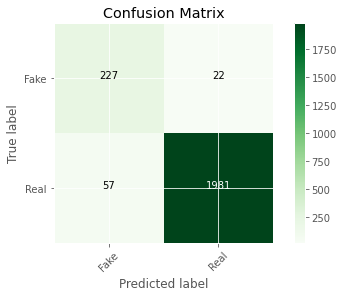

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(cm,classes = ['Fake','Real'])